# ホテリング理論（外れ値検知）


## 0.データ取得

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import pathlib
import os

In [ ]:
googledrive = True

In [ ]:
# ドライブのマウント
if googledrive:

    from google.colab import drive
    drive.mount('/content/drive/')
    # ここに成果物フォルダのパスを指定する
    %cd "/content/drive/MyDrive/AIQ2021_CoCreation_MaNiAC/"

pwd = pathlib.Path(".")
print("pwd:",pwd.resolve())
sorted([v for v in pwd.glob("*") if ".ipynb_checkpoints" not in str(v)])

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1R8RIgnShD3MN3kkS8rh6uzu1v6x_Pi9W/AIQ2021_CoCreation_MaNiAC
pwd: /content/drive/.shortcut-targets-by-id/1R8RIgnShD3MN3kkS8rh6uzu1v6x_Pi9W/AIQ2021_CoCreation_MaNiAC


[PosixPath('AutoEncoder_DEMO'),
 PosixPath('LICENSE'),
 PosixPath('README.ipynb'),
 PosixPath('dataset'),
 PosixPath('eda.ipynb'),
 PosixPath('fmt.ipynb'),
 PosixPath('github'),
 PosixPath('input'),
 PosixPath('matrix_profile.ipynb'),
 PosixPath('presentation'),
 PosixPath('sample_code'),
 PosixPath('事例紹介_関連文献'),
 PosixPath('報告資料')]

In [ ]:
INPUT_PATH = pwd/'input'/'currentdata'
current_file_list = sorted(INPUT_PATH.glob('*.csv'))
print(current_file_list)

[PosixPath('input/currentdata/current_day01.csv'), PosixPath('input/currentdata/current_day02.csv'), PosixPath('input/currentdata/current_day03.csv'), PosixPath('input/currentdata/current_day04.csv'), PosixPath('input/currentdata/current_day05.csv'), PosixPath('input/currentdata/current_day06.csv'), PosixPath('input/currentdata/current_day07.csv'), PosixPath('input/currentdata/current_day08.csv'), PosixPath('input/currentdata/current_day09.csv'), PosixPath('input/currentdata/current_day10.csv'), PosixPath('input/currentdata/current_day11.csv')]


In [ ]:
# 電流データをdf化

df_list = []
for i, file in enumerate(current_file_list):
    df_list.append(pd.read_csv(file,header=0, names=[f'time_day{i+1}',f'Current_day{i+1}']).fillna(0))

df_concat = pd.concat(df_list, axis=1)

df_concat.info()
df_concat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time_day1      900 non-null    int64  
 1   Current_day1   900 non-null    float64
 2   time_day2      894 non-null    float64
 3   Current_day2   894 non-null    float64
 4   time_day3      900 non-null    int64  
 5   Current_day3   900 non-null    float64
 6   time_day4      900 non-null    int64  
 7   Current_day4   900 non-null    float64
 8   time_day5      900 non-null    int64  
 9   Current_day5   900 non-null    float64
 10  time_day6      900 non-null    int64  
 11  Current_day6   900 non-null    float64
 12  time_day7      900 non-null    int64  
 13  Current_day7   900 non-null    float64
 14  time_day8      900 non-null    int64  
 15  Current_day8   900 non-null    float64
 16  time_day9      900 non-null    int64  
 17  Current_day9   900 non-null    float64
 18  time_day10

,time_day1,Current_day1,time_day2,Current_day2,time_day3,Current_day3,time_day4,Current_day4,time_day5,Current_day5,time_day6,Current_day6,time_day7,Current_day7,time_day8,Current_day8,time_day9,Current_day9,time_day10,Current_day10,time_day11,Current_day11
0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,58,0.0,60.0,0.0,60,0.0,63,0.0,60,0.0,58,0.0,59,0.0,62,0.0,59,0.0,58,0.0,59,0.0
2,118,0.0,118.0,0.0,120,0.0,120,0.0,118,0.0,118,0.0,117,0.0,138,0.0,117,0.0,119,0.0,118,0.0
3,176,0.0,178.0,0.0,178,0.0,178,0.0,178,0.0,176,0.0,177,0.0,177,0.0,177,0.0,178,0.0,178,0.0
4,236,0.0,237.0,0.0,238,0.0,239,0.0,236,0.0,236,0.0,235,0.0,235,0.0,237,0.0,236,0.0,237,0.0


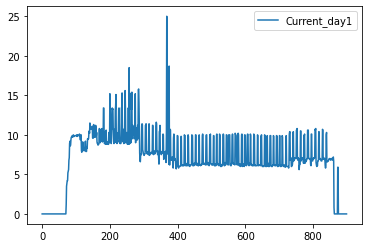

In [ ]:
# 電流データの可視化（1日）
day = 1
df_concat['Current_day'+str(day)].plot(x=df_concat['time_day'+str(day)],legend=True)

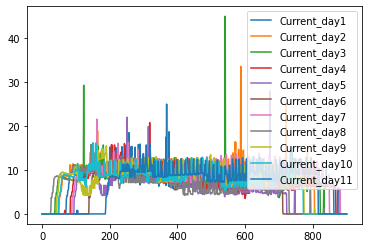

In [ ]:
# 電流データの可視化（全期間）
for x in range(len(current_file_list)):
    df_concat[f'Current_day{x+1}'].plot(x=df_concat[f'time_day{x+1}'],legend=True)

## 1.ホテリング理論の実装

データが正規分布に従うと仮定して異常値を検出する。


references:

https://axa.biopapyrus.jp/machine-learning/outlier-detection/%E3%83%9B%E3%83%86%E3%83%AA%E3%83%B3%E3%82%B0%E7%90%86%E8%AB%96.html

https://qiita.com/Zepprix/items/f6a5de2e3f6689bd2c1f

https://qiita.com/MasafumiTsuyuki/items/2677576849abf633e412

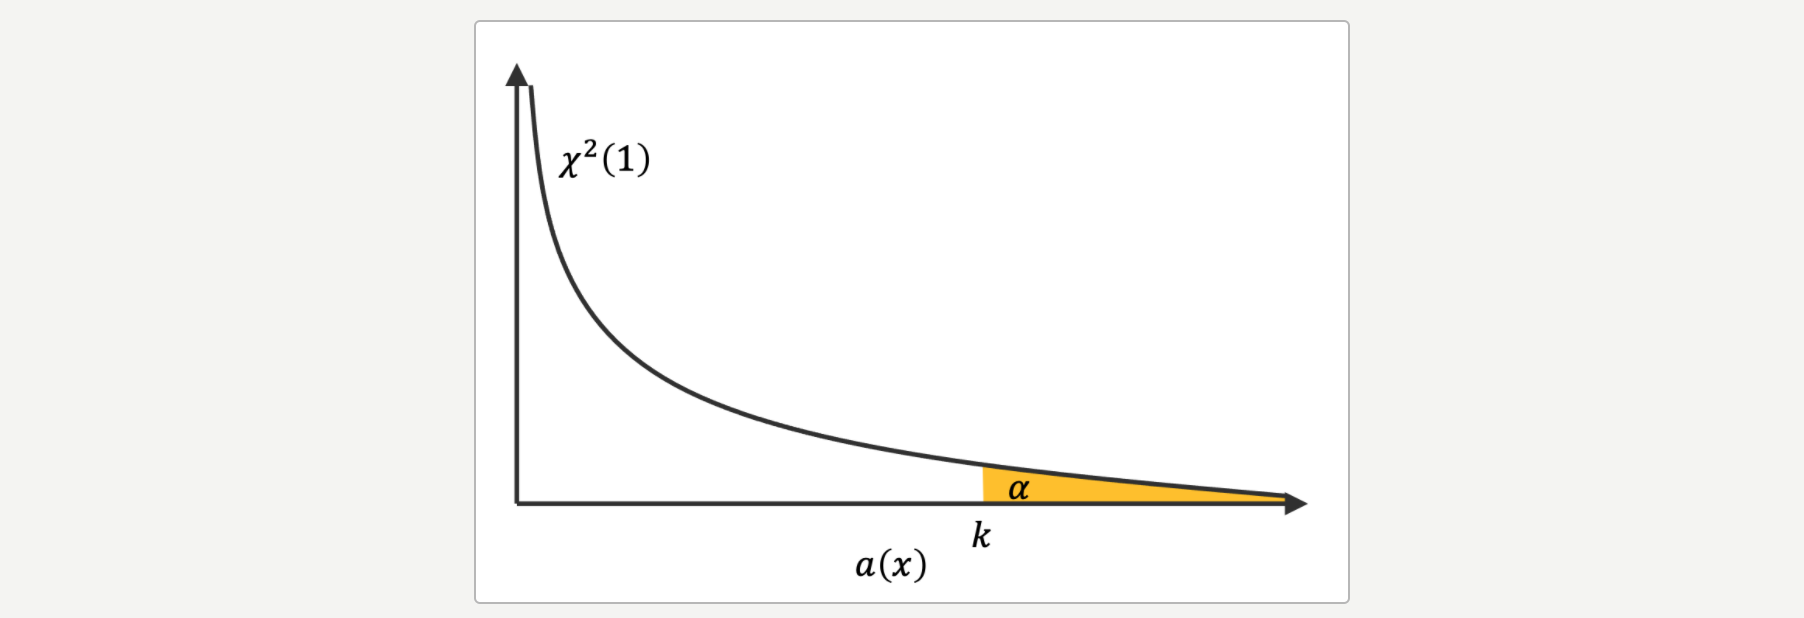

In [ ]:
from statistics import mean, variance
from scipy import stats
import matplotlib.pyplot as plt

def fit_hotelling(day):

    # データセットの読み込み
    data =   df_concat['Current_day'+str(day)].values.tolist()  #電流データを取得
    num = [i for i in range(len(data)) ]    #標本番号を取得

    # 標本平均
    mu = np.mean(data)
    # 標本分散
    var = variance(data)

    return mu, var


def test_hotelling(day, mu, var):

    # データセットの読み込み
    data =   df_concat['Current_day'+str(day)].values.tolist()  #電流データを取得
    num = [i for i in range(len(data)) ]    #標本番号を取得
    
    # 異常度計算
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - mu)**2 / var
        anomaly_scores.append(anomaly_score)

    # カイ二乗分布による片側0.01%水準の閾値
    threshold = stats.chi2.interval((1-2*0.001), 1)[1]
    print('threshold:',round(threshold,2))

    # 結果の描画
    plt.plot(num, data, color = "grey")
    plt.plot(num, anomaly_scores, "o", color = "b")
    plt.plot([0,900],[threshold, threshold], 'k-', color = "r", ls = "dashed")
    plt.xlabel("Sample number")
    plt.ylabel("Anomaly score")
    plt.ylim([0,100])
    plt.title("result")
    plt.show()

    return None

day1の電流データを正常として学習させて、

day2の電流データで異常検知を実施する。

threshold: 10.83


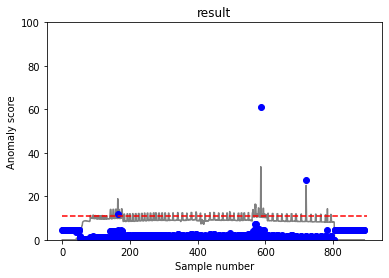

In [ ]:
fit_day = 1
predict_day = 2
mu,var = fit_hotelling(fit_day)
test_hotelling(predict_day, mu, var)